## Vizualise Textual Embeddings of Symbols Meaning Landscape and Dream Content  

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from shapely.geometry import MultiPoint
from scipy.spatial import ConvexHull
from transformers import CLIPTokenizer, CLIPModel
import torch


def map_words_to_semantic_space(word_dict, scaling_factor=2000, dim_red="tsne", savefig=False, savename='test'):
    # Load CLIP model and tokenizer
    model_name = "openai/clip-vit-base-patch32"
    tokenizer = CLIPTokenizer.from_pretrained(model_name)
    model = CLIPModel.from_pretrained(model_name)

    # Combine all words across authors
    all_words = []
    labels = []
    for author, words in word_dict.items():
        all_words.extend(words)
        labels.extend([author] * len(words))

    # Calculate embeddings for all words
    word_vectors = []
    for word in all_words:
        tokenized = tokenizer(word, return_tensors="pt", padding=True, truncation=True)
        with torch.no_grad():
            embedding = model.get_text_features(**tokenized)
        word_vectors.append(embedding.squeeze(0).numpy())

    word_vectors = np.array(word_vectors)

    # Dimensionality reduction
    if dim_red == "tsne":
        dim_red_model = TSNE(n_components=2, perplexity=6, random_state=42)
        word_vectors_2d = dim_red_model.fit_transform(word_vectors)
    else:
        raise ValueError(f"Invalid value for dim_red: {dim_red}. Only 'tsne' is supported.")

    # Create scatter plot and calculate convex hulls
    plt.figure(figsize=(10, 10))
    unique_authors = list(set(labels))
    colors = ['red', 'blue', 'green', 'purple', 'cyan', 'yellow', 'black', 'magenta', 'olive', 'navy', 'teal', 'lime', 'maroon']
    markers = ['.', ',', 'o', 'v', '^', '<', '>', 's', 'p', '*', 'h', 'H', '+', 'x', 'D', 'd']
    archetype_hulls = {}

    for i, author in enumerate(unique_authors):
        author_indices = [j for j, label in enumerate(labels) if label == author]
        x = word_vectors_2d[author_indices, 0]
        y = word_vectors_2d[author_indices, 1]
        archetype_points = MultiPoint([(x[j], y[j]) for j in range(len(x))])
        area = archetype_points.convex_hull.area
        print(author, 'area:', area)
        archetype_hulls[author] = archetype_points.convex_hull
        plt.scatter(x, y, marker=markers[i % len(markers)], alpha=0.5, color=colors[i], label=author)

        # Annotate each word on the scatter plot
        for j, word in enumerate(np.array(all_words)[author_indices]):
            plt.annotate(word, (x[j], y[j]), fontsize=8, ha='center', va='center', color='black')

    for e, (author, hull) in enumerate(archetype_hulls.items()):
        plt.fill(*zip(*hull.exterior.coords), alpha=0.2, color=colors[e])

    plt.legend(title='Archetypes', fontsize=12, title_fontsize=14, loc='upper right')
    plt.title('CLIP Word Embeddings Visualized')

    if savefig:
        plt.savefig(savename + '.png', dpi=300)
    else:
        plt.show()

    return archetype_hulls




def plot_archetype_heatmap(archetype_hulls):
    archetypes = list(archetype_hulls.keys())
    num_archetypes = len(archetypes)
    heatmap = np.zeros((num_archetypes, num_archetypes))

    for i in range(num_archetypes):
        for j in range(num_archetypes):
            if i >= j:
                continue
            hull1 = MultiPoint([point for point in archetype_hulls[archetypes[i]].exterior.coords])
            hull2 = MultiPoint([point for point in archetype_hulls[archetypes[j]].exterior.coords])
            intersection = hull1.convex_hull.intersection(hull2.convex_hull).area
            heatmap[i, j] = intersection
            heatmap[j, i] = intersection

    mask = np.triu(np.ones_like(heatmap, dtype=bool))
    plt.figure(figsize=(10, 8))
    sns.heatmap(heatmap, mask=mask, annot=True, fmt=".2f", cmap="viridis", xticklabels=archetypes, yticklabels=archetypes)
    plt.title("Shared Areas Between Symbols")
    plt.show()


lakota_symbols = {
    "Bag": ["purpose", "treasure", "hidden potential"],
    "Clouds": ["impermanence", "veil", "drift", "illumination"],
    "Dragonfly": ["agility", "metamorphosis", "firelight"],
    "Earth": ["stability", "roots", "maternal strength"],
    "Earth2": ["renewal", "seasons", "circle of life"],
    "Feather": ["elevation", "weightlessness", "divine message"],
    "Horse Track": ["exploration", "trail", "momentum"],
    "House": ["protection", "hearth", "community bond"],
    "Lightning": ["rupture", "electricity", "divine spark"],
    "Star": ["guidance", "eternity", "celestial beacon"],
    "Thunder": ["resonance", "impact", "elemental roar"]
}



#archetype_hulls = map_words_to_semantic_space(lakota_symbols, dim_red="tsne")
#plot_archetype_heatmap(archetype_hulls)


MY DREAM area: 48.17
Horse Track area: 1.17
Earth2 area: 9.79
Lightning area: 4.24
House area: 33.34
Bag area: 0.66
Dragonfly area: 28.16
Earth area: 25.42
Thunder area: 14.42
Clouds area: 26.87
Star area: 21.13
Feather area: 15.99


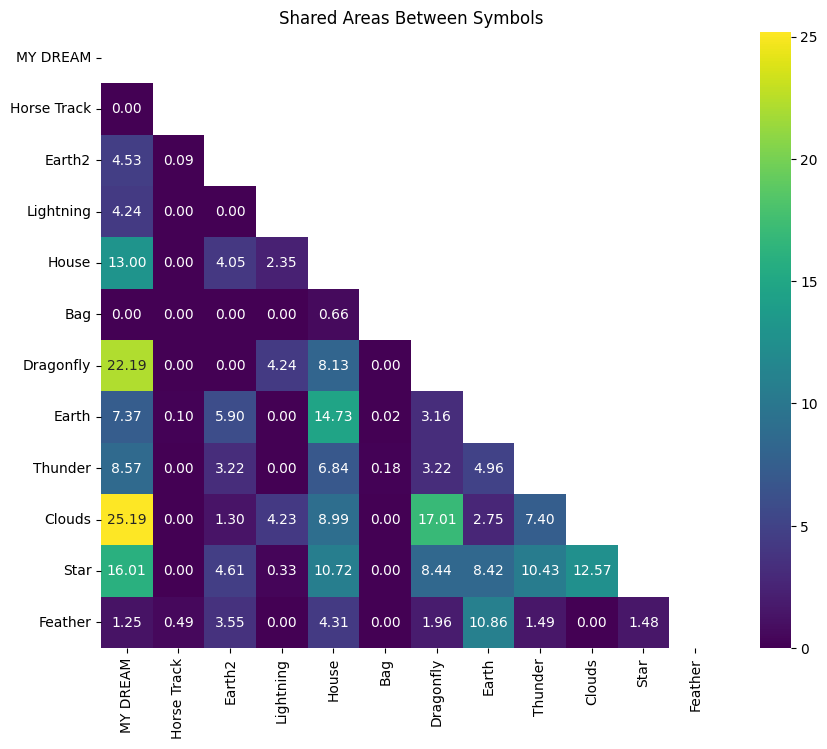

In [36]:
import numpy as np
import plotly.graph_objects as go
from sklearn.manifold import TSNE
from shapely.geometry import MultiPoint
from scipy.spatial import ConvexHull
from transformers import CLIPTokenizer, CLIPModel
import torch
from sklearn.decomposition import PCA
from umap import UMAP


def map_words_to_semantic_space_dynamic(word_dict, scaling_factor=2000, dim_red="tsne"):
    # Load CLIP model and tokenizer
    model_name = "openai/clip-vit-base-patch32"
    tokenizer = CLIPTokenizer.from_pretrained(model_name)
    model = CLIPModel.from_pretrained(model_name)

    # Combine all words across archetypes
    all_words = []
    labels = []
    for archetype, words in word_dict.items():
        all_words.extend(words)
        labels.extend([archetype] * len(words))

    # Calculate embeddings for all words
    word_vectors = []
    for word in all_words:
        tokenized = tokenizer(word, return_tensors="pt", padding=True, truncation=True)
        with torch.no_grad():
            embedding = model.get_text_features(**tokenized)
        word_vectors.append(embedding.squeeze(0).numpy())

    word_vectors = np.array(word_vectors)

    # Dimensionality reduction
    # Dimensionality reduction
    if dim_red == "tsne":
        dim_red_model = TSNE(n_components=2, perplexity=12, random_state=42)
        word_vectors_2d = dim_red_model.fit_transform(word_vectors)
    elif dim_red == "pca":
        dim_red_model = PCA(n_components=2)
        word_vectors_2d = dim_red_model.fit_transform(word_vectors)
    elif dim_red == "umap":
        dim_red_model = UMAP(n_components=2, random_state=42)
        word_vectors_2d = dim_red_model.fit_transform(word_vectors)
    else:
        raise ValueError(f"Invalid value for dim_red: {dim_red}. Supported values: 'tsne', 'pca', 'umap'.")

    return word_vectors_2d, labels, all_words


def create_dynamic_plot(word_vectors_2d, labels, all_words):
    # Create a Plotly figure
    fig = go.Figure()

    unique_archetypes = list(set(labels))
    base_colors = [
        'rgba(255, 0, 0, 1)',    # Red
        'rgba(0, 0, 255, 1)',    # Blue
        'rgba(0, 255, 0, 1)',    # Green
        'rgba(128, 0, 128, 1)',  # Purple
        'rgba(0, 255, 255, 1)',  # Cyan
        'rgba(255, 255, 0, 1)',  # Yellow
        'rgba(0, 0, 0, 1)',      # Black
        'rgba(255, 0, 255, 1)',  # Magenta
        'rgba(128, 128, 0, 1)',  # Olive
        'rgba(0, 0, 128, 1)',    # Navy
        'rgba(0, 128, 128, 1)',  # Teal
        'rgba(0, 128, 0, 1)',    # Lime
    ]

    archetype_hulls = {}

    for i, archetype in enumerate(unique_archetypes):
        # Get points for the current archetype
        archetype_indices = [j for j, label in enumerate(labels) if label == archetype]
        x = word_vectors_2d[archetype_indices, 0]
        y = word_vectors_2d[archetype_indices, 1]

        # Calculate convex hull and area
        archetype_points = MultiPoint([(x[j], y[j]) for j in range(len(x))])
        hull = archetype_points.convex_hull
        area = hull.area
        archetype_hulls[archetype] = hull

        print(f"{archetype} area: {area:.2f}")

        # Add scatter plot for archetype points
        fig.add_trace(go.Scatter(
            x=x, y=y,
            mode='markers+text',
            marker=dict(size=10, color=base_colors[i % len(base_colors)], opacity=0.7),
            text=np.array(all_words)[archetype_indices],
            textposition="top center",
            name=f"{archetype} Points",
            legendgroup=archetype,  # Group the points and hull together
            showlegend=True         # Show legend only for the points
        ))

        # Add convex hull for archetype
        if len(x) > 2:  # Only plot hull if it exists
            hull_coords = np.array(hull.exterior.coords)
            fig.add_trace(go.Scatter(
                x=hull_coords[:, 0].tolist() + [hull_coords[0, 0]],
                y=hull_coords[:, 1].tolist() + [hull_coords[0, 1]],
                fill='toself',
                fillcolor=base_colors[i % len(base_colors)].replace('1)', '0.2)'),
                line=dict(color=base_colors[i % len(base_colors)]),
                name=f"{archetype} Hull",
                legendgroup=archetype,  # Group the hull with the points
                showlegend=False        # Do not show a separate legend for the hull
            ))

    # Update plot layout
    fig.update_layout(
        title="Semantic Map with Convex Hulls",
        xaxis_title="Dimension 1",
        yaxis_title="Dimension 2",
        width=900,
        height=800
    )
    # Remove gridlines
    fig.update_xaxes(showgrid=False)
    fig.update_yaxes(showgrid=False)
    # Remove background color
    fig.update_layout(plot_bgcolor='rgba(0,0,0,0)')
    fig.write_html("dynamic_semantic_map.html")
    fig.show()

    return archetype_hulls



# Lakota symbols
lakota_symbols = {
    "Bag": ["purpose", "treasure", "hidden potential"],
    "Clouds": ["impermanence", "veil", "drift", "illumination"],
    "Dragonfly": ["agility", "metamorphosis", "firelight"],
    "Earth": ["stability", "roots", "maternal strength"],
    "Earth2": ["renewal", "seasons", "circle of life"],
    "Feather": ["elevation", "weightlessness", "divine message"],
    "Horse Track": ["exploration", "trail", "momentum"],
    "House": ["protection", "hearth", "community bond"],
    "Lightning": ["rupture", "electricity", "divine spark"],
    "Star": ["guidance", "eternity", "celestial beacon"],
    "Thunder": ["resonance", "impact", "elemental roar"],
    "MY DREAM": ["dragon", "reptile", "light", "memory", "sky"],
}

# Map words to semantic space
word_vectors_2d, labels, all_words = map_words_to_semantic_space_dynamic(lakota_symbols, dim_red="tsne")

# Create dynamic plot
hulls = create_dynamic_plot(word_vectors_2d, labels, all_words)
plot_archetype_heatmap(hulls)
